In [1]:
import sys
sys.path.append("..")

In [18]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from hrdae.models.networks import create_network, RDAE2dOption, AutoEncoder2dNetworkOption
from hrdae.models.networks.motion_encoder import MotionRNNEncoder1dOption
from hrdae.models.networks.rnn import TCN1dOption
from hrdae.dataloaders.datasets import create_dataset, MovingMNISTDatasetOption
from hrdae.dataloaders.transforms import create_transform, MinMaxNormalizationOption


# contrastive autoencoderの効果測定

In [3]:
# results/BasicDataLoaderOption/BasicModelOption/AutoEncoder2dNetworkOption/2024-07-02_07-37-26/options.yaml
net = create_network(
    1,
    opt=AutoEncoder2dNetworkOption(
        activation="sigmoid",
        hidden_channels=64,
        latent_dim=32,
        conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 4,
    )
)

In [4]:
net.load_state_dict(torch.load("../results/BasicDataLoaderOption/BasicModelOption/AutoEncoder2dNetworkOption/2024-07-02_07-37-26/weights/best_model.pth"))

<All keys matched successfully>

In [5]:
net.eval()

AutoEncoder2d(
  (encoder): AEEncoder2d(
    (cnn): HierarchicalConvEncoder2d(
      (layers): ModuleList(
        (0): Sequential(
          (0): ConvBlock2d(
            (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          )
          (1): IdenticalConvBlock2d(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (1-3): 3 x Sequential(
          (0): ConvBlock2d(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          )
          (1): IdenticalConvBlock2d(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (4): ConvBlock2d(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (bottleneck): PixelWiseConv2d(
      (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (decoder): AEDecoder2d(
    (bottleneck): PixelWise

In [6]:
dataset = create_dataset(
    opt=MovingMNISTDatasetOption(
        sequential=True,
        root="../data",
        slice_index=[16, 24, 32, 40, 48],
        content_phase="0",
        motion_phase="0",
        motion_aggregation="none",
    ),
    transform=transforms.Compose([
        create_transform(MinMaxNormalizationOption()),
    ]),
    is_train=False,
)

In [12]:
loader = DataLoader(dataset=dataset, batch_size=8, shuffle=False)

torch.Size([8, 10, 1, 64, 64])
torch.Size([80, 1, 64, 64]) torch.Size([80, 32, 4, 4])


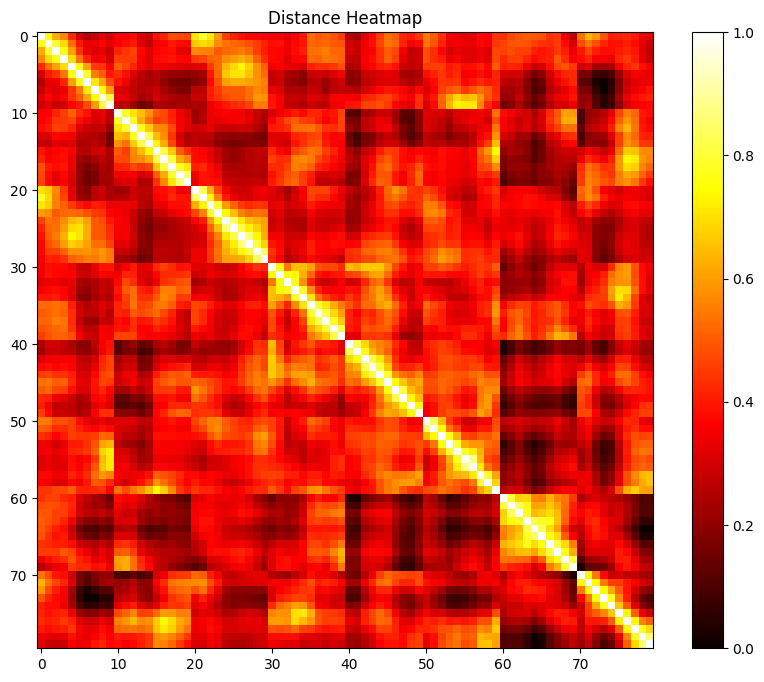

In [20]:
for data in loader:
    xp = data["xp"]
    print(xp.shape)
    y, latent = net(xp.reshape(80, 1, 64, 64))
    print(y.shape, latent.shape)

    latent = latent.clone().detach()

    distances = torch.cdist(latent.view(80, -1), latent.view(80, -1))

    # 距離の最大値で正規化し、距離が小さいほど赤くするために1から引く
    normalized_distances = 1.0 - distances / distances.max()

    # ヒートマップの描画
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_distances, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Distance Heatmap')
    plt.show()
    
    # 同じframeのlatentはどのくらい似ているか

    # for i in range(10):
    #     for j in range(10):
    #         if i != j:
    #             print(i, j, ((latents[i][0]-latents[j][0])**2).mean())
    #         else:
    #             mse = 0.
    #             for k in range(10):
    #                 mse += ((latents[i][0] - latents[i][k])**2).mean()
    #             print(i, i, mse / 10)
    # for i in range(len(y)):
    #     for j in range(len(y)):
    #         if i == j:
    #             l1 = 0.
    #             for _xp_0 in xp[i]:
    #                 l2 = net.content_encoder(_xp_0.unsqueeze(0)).squeeze()
    #                 l1 += float(((latent[0][i]-l2)**2).mean())
    #                 print(float(((latent[0][i]-l2)**2).mean()))
    #             print(f"i={i} / j={j}", l1 / len(xp[i]))
    #             continue
    #         print(f"i={i} / j={j}", float(((latent[0][i]-latent[0][j])**2).mean()))
    #     print("mse:", float(((y[i]-xp[i])**2).mean()))

    break

In [22]:
net.load_state_dict(torch.load("../results/BasicDataLoaderOption/BasicModelOption/AutoEncoder2dNetworkOption/2024-06-28_06-30-41/weights/best_encoder.pth"))

RuntimeError: Error(s) in loading state_dict for AutoEncoder2d:
	Missing key(s) in state_dict: "encoder.cnn.layers.0.0.conv.weight", "encoder.cnn.layers.0.0.conv.bias", "encoder.cnn.layers.0.1.conv.weight", "encoder.cnn.layers.0.1.conv.bias", "encoder.cnn.layers.1.0.conv.weight", "encoder.cnn.layers.1.0.conv.bias", "encoder.cnn.layers.1.1.conv.weight", "encoder.cnn.layers.1.1.conv.bias", "encoder.cnn.layers.2.0.conv.weight", "encoder.cnn.layers.2.0.conv.bias", "encoder.cnn.layers.2.1.conv.weight", "encoder.cnn.layers.2.1.conv.bias", "encoder.cnn.layers.3.0.conv.weight", "encoder.cnn.layers.3.0.conv.bias", "encoder.cnn.layers.3.1.conv.weight", "encoder.cnn.layers.3.1.conv.bias", "encoder.cnn.layers.4.conv.weight", "encoder.cnn.layers.4.conv.bias", "encoder.bottleneck.conv.weight", "encoder.bottleneck.conv.bias", "decoder.bottleneck.conv.weight", "decoder.bottleneck.conv.bias", "decoder.cnn.layers.0.0.conv.weight", "decoder.cnn.layers.0.0.conv.bias", "decoder.cnn.layers.0.1.conv.weight", "decoder.cnn.layers.0.1.conv.bias", "decoder.cnn.layers.1.0.conv.weight", "decoder.cnn.layers.1.0.conv.bias", "decoder.cnn.layers.1.1.conv.weight", "decoder.cnn.layers.1.1.conv.bias", "decoder.cnn.layers.2.0.conv.weight", "decoder.cnn.layers.2.0.conv.bias", "decoder.cnn.layers.2.1.conv.weight", "decoder.cnn.layers.2.1.conv.bias", "decoder.cnn.layers.3.conv.weight", "decoder.cnn.layers.3.conv.bias". 
	Unexpected key(s) in state_dict: "cnn.layers.0.0.conv.weight", "cnn.layers.0.0.conv.bias", "cnn.layers.0.1.conv.weight", "cnn.layers.0.1.conv.bias", "cnn.layers.1.0.conv.weight", "cnn.layers.1.0.conv.bias", "cnn.layers.1.1.conv.weight", "cnn.layers.1.1.conv.bias", "cnn.layers.2.0.conv.weight", "cnn.layers.2.0.conv.bias", "cnn.layers.2.1.conv.weight", "cnn.layers.2.1.conv.bias", "cnn.layers.3.0.conv.weight", "cnn.layers.3.0.conv.bias", "cnn.layers.3.1.conv.weight", "cnn.layers.3.1.conv.bias", "cnn.layers.4.conv.weight", "cnn.layers.4.conv.bias", "bottleneck.conv.weight", "bottleneck.conv.bias". 

In [21]:
((xp_0 - xp[:, 0])**2).mean()

tensor(0.)

In [53]:
import torch
import torch.nn.functional as F

In [80]:
def contrastive_loss(features, tau=0.1):
    """
    Compute contrastive loss for features in shape (t, n, c)
    :param features: Tensor of shape (t=num_classes, n=samples_per_class, c=feature_dim)
    :param tau: Temperature scaling parameter
    :return: Contrastive loss
    """
    t, n, c = features.size()
    features = features.view(t * n, c)
    square_distances = torch.cdist(features, features, p=2)

    labels = 1 - torch.eye(t*n).to(features.device)  # 同じ要素は0、それ以外は1
    for i in range(t):
        labels[i*n:(i+1)*n, i*n:(i+1)*n] = 0

    positive_loss = (1 - labels) * 0.5 * torch.pow(square_distances, 2)
    negative_loss = labels * 0.5 * torch.pow(torch.clamp(tau - square_distances, min=0.0), 2)
    
    loss = torch.sum(positive_loss + negative_loss) / (t * n * (t * n - 1))
    
    return loss


In [81]:
# Example tensor with random data
num_classes = 4
samples_per_class = 3
feature_dim = 10

# Randomly generate features
features = torch.randn(num_classes, samples_per_class, feature_dim)

# Compute loss
loss = contrastive_loss(features)
print("Contrastive Loss:", loss.item())

Contrastive Loss: 1.3802295923233032


In [82]:
contrastive_loss(torch.randn(4, 1, 1).repeat(1, 3, 10))

tensor(0.0002)